# MNIST Gradient Descent NNs

## Load Data

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

np.set_printoptions(suppress=True)
np.seterr(divide = 'ignore') 

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

# normalisation
X_train = X_train / 255
X_test = X_test / 255

def createY(y):
    Y = np.zeros(10)
    Y[y] = 1
    return Y

# reshape
X_train = X_train.reshape(60000, 28 ** 2)
X_test = X_test.reshape(10000, 28 ** 2)
y_train = np.array([createY(y) for y in y_train])
y_test =np.array([createY(y) for y in y_test])

# tensorflow
X_train = tf.constant(X_train, dtype=tf.float64)
X_test = tf.constant(X_test, dtype=tf.float64)
y_train = tf.constant(y_train, dtype=tf.float64)
y_test = tf.constant(y_test, dtype=tf.float64)

11493376/11490434 [==============================] - 0s 0us/step


## Initialize HyperParameters

In [99]:
def inistial_parameters(n, dims):
    
    W = {}
    B = {}
    
    for i in range(len(dims)):
        dim = dims[i]
        if i == 0:
            w =  np.random.rand(n, dim) * 1e-3 #* (np.sqrt(2 / dim))
            W['W' + str(i + 1)] = tf.constant(w)
            b = np.zeros((1, dim))
            B['b' + str(i + 1)] = tf.constant(b)
        else:
            w = np.random.rand(dims[i-1], dim) * 1e-3 #* (np.sqrt(2 / dim))
            W['W' + str(i + 1)] = tf.constant(w)
            b = np.zeros((1, dim))
            B['b' + str(i + 1)] = tf.constant(b)
            
    return {
        'W' : W,
        'b' : B
    }

## Linear Regression

In [4]:
def linear(X, W, b):
    return np.dot(X, W) + b

## ReLU

In [5]:
def relu(X):
    return np.maximum(X, 0)

## Softmax

In [117]:
def softmax(X):
    return np.exp(X) / (np.sum(np.exp(X), axis=1, keepdims=True)) 

## Activation function

In [118]:
def activation(A_prev, W, b, active):
    """
    activation - sigmoid/relu/softmax
    """
    
    if active == 'sigmoid':
        Z = linear(A_prev, W, b)
        A = sigmoid(Z)
    elif active == 'relu':
        Z = linear(A_prev, W, b)
        A = relu(Z)
    elif active == 'softmax':
        Z = linear(A_prev, W, b)
        A = softmax(Z)
        
    return A, Z

## L model forward

In [133]:
def L_model_forward(X, W, b):
    A = X
    L = len(b)
    # caches = {}
    
    # caches['A0'] = A
    
    for i in range(1, L):
        A_prev = A
        
        A, Z = activation(A_prev, W['W' + str(i)], b['b' + str(i)], 'relu')
        # caches['A' + str(i)] = A
        # caches['Z' + str(i)] = Z
        
    AL, ZL = activation(A, W['W' + str(L)], b['b' + str(L)], 'softmax')
    # caches['A' + str(L)] = AL
    # caches['Z' + str(L)] = ZL
    
    return AL

## CrossEntropy

In [47]:
def crossEntropy(haty, Y):
    m = haty.shape[0]

    ce = np.sum(Y * np.log(haty))

    return - ce / m


## Train

In [10]:
def SGDRange(m, setpsize):
  sum = m
  setpsize = setpsize

  rangeArr = []

  for i in range(0, (sum // setpsize) * setpsize, setpsize):
    rangeArr.append([i, i + setpsize])
    
  if sum % setpsize != 0:
    lastone = sum // setpsize * setpsize
    rangeArr.append([lastone, lastone + sum % setpsize])
  return rangeArr

# debug
# rangeArr = SGDRange(124, 50)
# print(rangeArr)

In [155]:
n = X_train.shape[1]
alpha = 0.1

dims = [512, 10]
L = len(dims)

parameters = inistial_parameters(n, dims)
W = parameters['W']
b = parameters['b']

# AL, caches = L_model_forward(X_train, W, b)

cost_train = []
cost_test = []

def backpropagation(X, y):
    m = X.shape[0]

    with tf.GradientTape(persistent=True) as g:
        
        for i in range(1, L + 1):
            g.watch(W['W' + str(i)])
            g.watch(b['b' + str(i)])

        # ReLU
        A_previous = X
        for i in range(1, L):
            L_hidden = tf.experimental.numpy.dot(A_previous, W['W' + str(i)]) + b['b' + str(i)]
            A_previous = tf.math.maximum(L_hidden, 0) 

        # softmax
        LL = tf.experimental.numpy.dot(A_previous, W['W' + str(L)]) + b['b' + str(L)]
        AL = (tf.experimental.numpy.exp(LL)) / (tf.experimental.numpy.sum(tf.experimental.numpy.exp(LL), axis=1, keepdims=True)) 

        # cost function
        J = - tf.experimental.numpy.sum(y * tf.experimental.numpy.log(AL)) / m
    
    for i in range(1, L + 1):
        
        dJ_W = g.gradient(J, W['W' + str(i)])
        dJ_b = g.gradient(J, b['b' + str(i)])

        W['W' + str(i)] = W['W' + str(i)] - alpha * dJ_W
        b['b' + str(i)] = b['b' + str(i)] - alpha * dJ_b

iteration = 40
for i in range(iteration):

  rangeArr = SGDRange(X_train.shape[0], 512)
  for index in rangeArr:
    backpropagation(X_train[index[0]:index[1]], y_train[index[0]:index[1]])

  cost_train.append(crossEntropy(L_model_forward(X_train, W, b), y_train))
  cost_test.append(crossEntropy(L_model_forward(X_test, W, b), y_test))

  if i % 5 == 0 or i == iteration - 1:
    print('====enoch == {enoch}===='.format(enoch=i))
    print('cost_train: {cost_train}'.format(cost_train=cost_train[i]))
    print('cost_test: {cost_test}'.format(cost_test=cost_test[i]))



====enoch == 0====
cost_train: 1.8548113138501496
cost_test: 1.8487181353236364
====enoch == 5====
cost_train: 0.33314830552861474
cost_test: 0.3207902396756074
====enoch == 10====
cost_train: 0.2608547719958258
cost_test: 0.2539351984361
====enoch == 15====
cost_train: 0.21919503580246602
cost_test: 0.21618257274610883
====enoch == 20====
cost_train: 0.1874554712797584
cost_test: 0.1877229193072557
====enoch == 25====
cost_train: 0.1622951713946909
cost_test: 0.16558925983414707
====enoch == 30====
cost_train: 0.14209353176100312
cost_test: 0.14837629471554883
====enoch == 35====
cost_train: 0.12583190484241596
cost_test: 0.13502552254786715
====enoch == 39====
cost_train: 0.11489892558275143
cost_test: 0.12632355923072014


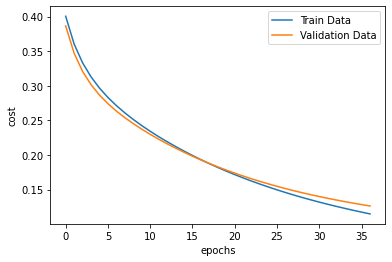

In [165]:
import matplotlib.pyplot as plt

plt.plot(cost_train[3:], label="Train Data")
plt.plot(cost_test[3:], label="Validation Data")
# print(np.max(current_percentage))
# plt.plot(current_percentage[:], label="Current Test")
plt.ylabel('cost')
plt.xlabel('epochs')
plt.legend()
plt.show()

## get correct percentage

In [164]:
def getCorrectPercentage(X, y):
  m = len(X)
  hatys = L_model_forward(X, W, b)
  hatys = np.array([createY(np.argmax(y)) for y in hatys])
  corrent_num = np.sum(y * hatys)
  return corrent_num / m

print(getCorrectPercentage(X_train, y_train))
print(getCorrectPercentage(X_test, y_test))

0.96775
0.9634


[[0.00073256 0.00001257 0.98909534 0.00980678 0.         0.00014338
  0.00013979 0.         0.00006959 0.        ]]
2


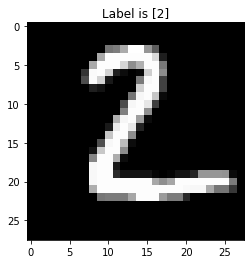

In [166]:
## Test
index = 1
single_label = np.where(y_test[index] == 1)[0]
single_Image = X_test[index].numpy()
single_Image_r = single_Image.reshape((28, 28))
test = L_model_forward(single_Image, W, b)
print(test)
print(np.argmax(test))
plt.title('Label is {label}'.format(label=single_label))
plt.imshow(single_Image_r, cmap='gray')
plt.show()

In [ ]:
test_data = pd.read_csv('/content/test.csv')
test_data.describe()

In [ ]:
hatys = []
for single_Image in test_data.values:
    haty, _ = L_model_forward(single_Image, W, b)
    hatys.append(np.argmax(haty))
    
hatys = pd.DataFrame(zip(range(1, len(hatys) + 1), hatys), columns=['ImageId', 'Label'])

In [ ]:
hatys.to_csv('submission.csv', index=False)

In [171]:
import pickle

# save pickle
filename = 'model.pkl'
model = {'W': W, 'b': b}
pickle.dump( model, open( filename, "wb" ) )

In [172]:
# load pickle
model = pickle.load( open( filename, "rb" ) )
print(model)

{'W': {'W1': <tf.Tensor: shape=(784, 512), dtype=float64, numpy=
array([[0.00007052, 0.00031088, 0.00046427, ..., 0.00020095, 0.00058982,
        0.00037155],
       [0.00094162, 0.00033412, 0.00005369, ..., 0.00084005, 0.00024343,
        0.00028632],
       [0.00011479, 0.00013361, 0.0006291 , ..., 0.00056153, 0.00045227,
        0.00046649],
       ...,
       [0.0005287 , 0.00067129, 0.00099096, ..., 0.00049941, 0.00044009,
        0.00030906],
       [0.0005068 , 0.00011449, 0.0006989 , ..., 0.00050274, 0.0009818 ,
        0.00004772],
       [0.00081491, 0.00044808, 0.00084113, ..., 0.0002476 , 0.00015903,
        0.00040266]])>, 'W2': <tf.Tensor: shape=(512, 10), dtype=float64, numpy=
array([[ 0.16104558,  0.02714529, -0.25999882, ...,  0.03548292,
        -0.12990298,  0.07023398],
       [ 0.04636511, -0.18710089,  0.06092795, ...,  0.27540427,
        -0.11042503,  0.21095396],
       [-0.01902534, -0.06840108,  0.12026054, ...,  0.01187856,
        -0.03279985, -0.02698136],